## **Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno 
import joblib   
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## **Load the Data**

In [2]:
df = pd.read_csv('lazada_products_dataset.csv')
df.columns

Index(['classification', 'title', 'category', 'ave_rating', 'num_ratings',
       'reviews_total_5_stars', 'reviews_total_4_stars',
       'reviews_total_3_stars', 'reviews_total_2_stars',
       'reviews_total_1_stars', 'seller_name', 'seller_rating',
       'ships_on_time', 'chat_response_rate', 'price', 'reviews', 'sentiment'],
      dtype='object')

## **Data Exploration**

In [3]:
print("\nData Types for each column:")
print(df.dtypes)


Data Types for each column:
classification            object
title                     object
category                  object
ave_rating               float64
num_ratings               object
reviews_total_5_stars      int64
reviews_total_4_stars      int64
reviews_total_3_stars      int64
reviews_total_2_stars      int64
reviews_total_1_stars      int64
seller_name               object
seller_rating            float64
ships_on_time            float64
chat_response_rate        object
price                    float64
reviews                   object
sentiment                 object
dtype: object


In [4]:
null_counts = df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
classification            0
title                     0
category                  0
ave_rating                0
num_ratings               0
reviews_total_5_stars     0
reviews_total_4_stars     0
reviews_total_3_stars     0
reviews_total_2_stars     0
reviews_total_1_stars     0
seller_name               0
seller_rating            10
ships_on_time            21
chat_response_rate        6
price                     0
reviews                   0
sentiment                 0
dtype: int64



Check missing values


<Figure size 100x300 with 0 Axes>

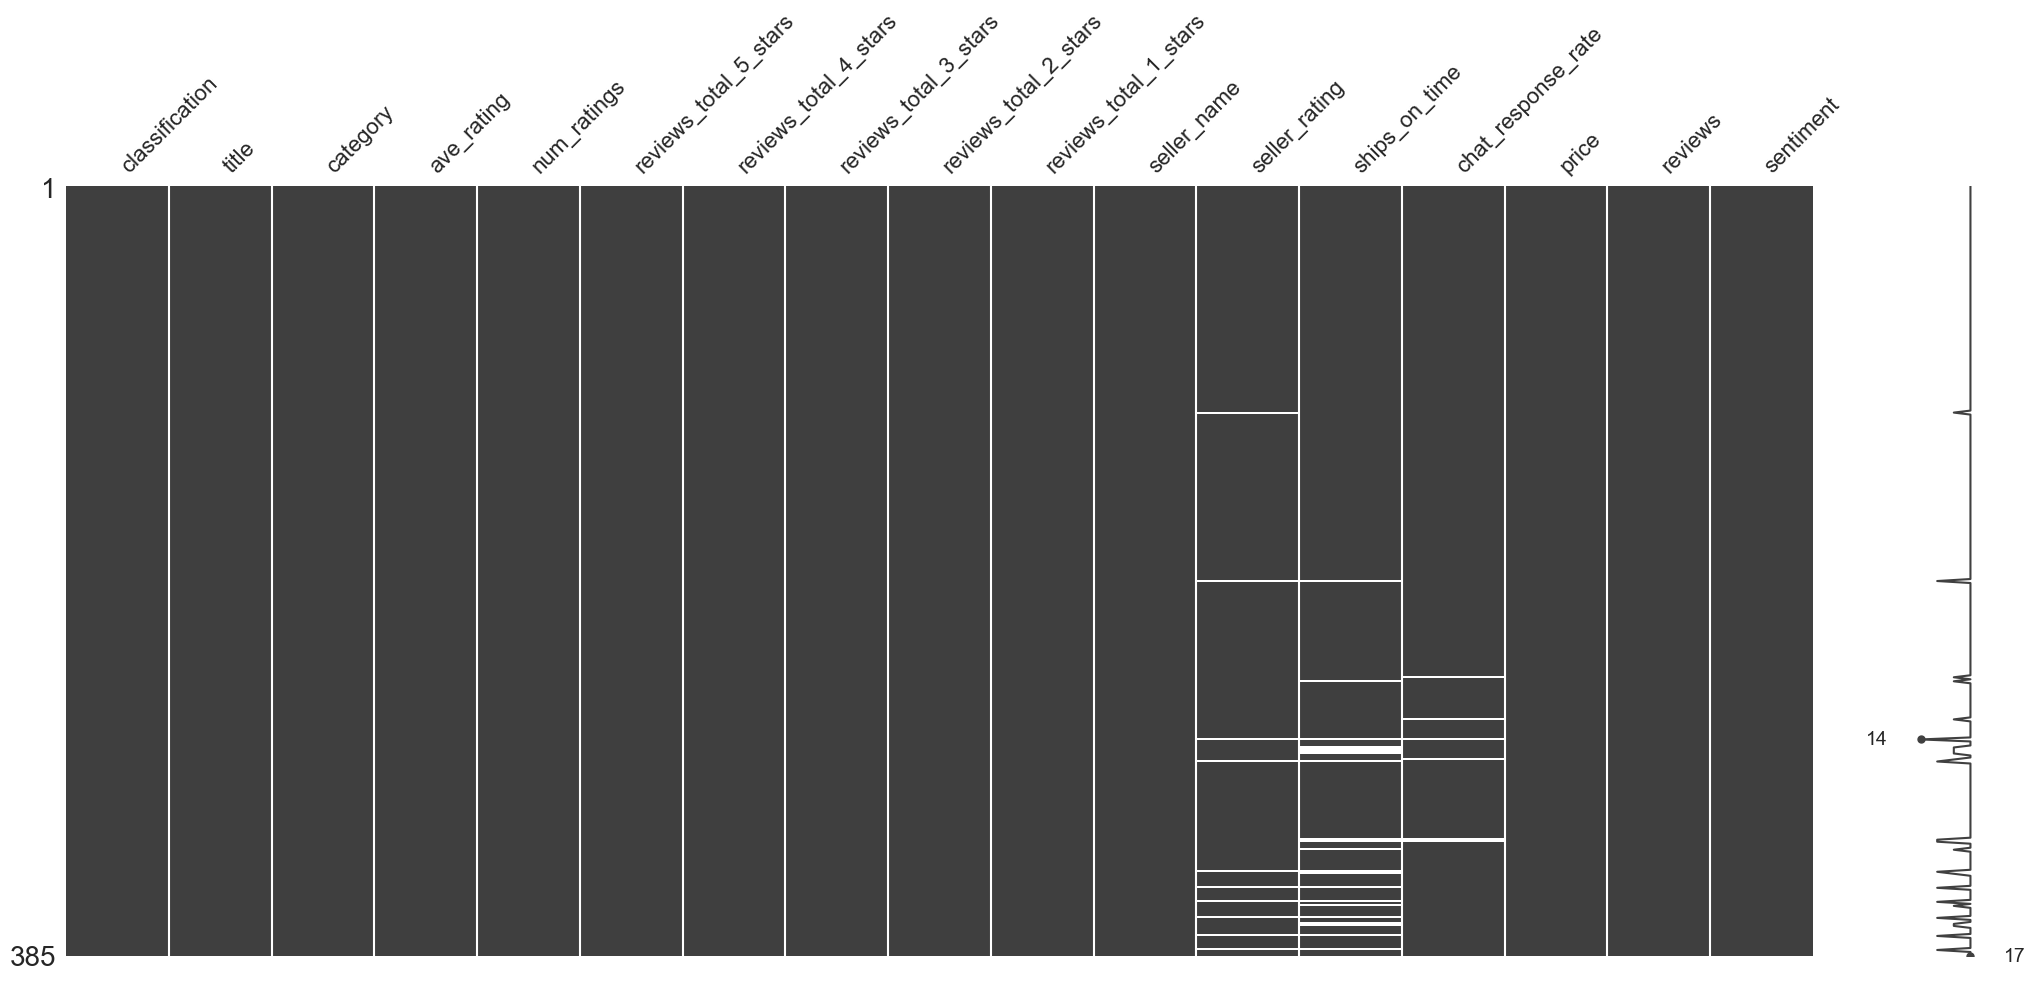

In [5]:
print("\nCheck missing values")

sns.set_style("whitegrid")
plt.figure(figsize=(1, 3))

msno.matrix(df)

plt.show()

## **Data Cleaning**

In [6]:
df['num_ratings'] = pd.to_numeric(df['num_ratings'].str.replace(',', ''), errors='coerce')
df['chat_response_rate'] = pd.to_numeric(df['chat_response_rate'].str.replace('%', ''), errors='coerce') / 100
df.fillna({'num_ratings': 0, 'chat_response_rate': df['chat_response_rate'].mean()}, inplace=True)

## **Feature Engineering**

In [7]:
df['combined_text'] = df['title']
df.columns

Index(['classification', 'title', 'category', 'ave_rating', 'num_ratings',
       'reviews_total_5_stars', 'reviews_total_4_stars',
       'reviews_total_3_stars', 'reviews_total_2_stars',
       'reviews_total_1_stars', 'seller_name', 'seller_rating',
       'ships_on_time', 'chat_response_rate', 'price', 'reviews', 'sentiment',
       'combined_text'],
      dtype='object')

In [8]:
tfidf_vectorizer = TfidfVectorizer()
X_text = tfidf_vectorizer.fit_transform(df['combined_text'])

In [9]:
review_columns = ['reviews_total_5_stars', 'reviews_total_4_stars', 'reviews_total_3_stars',
                  'reviews_total_2_stars', 'reviews_total_1_stars']
X_reviews = df[review_columns].values

In [10]:
seller_metrics = ['seller_rating', 'ships_on_time', 'chat_response_rate']
X_seller = df[seller_metrics].values

In [11]:
X_combined = np.hstack((X_text.toarray(), X_reviews, X_seller)) 
y = df['classification'].map({'Fake': 0, 'Legit': 1})

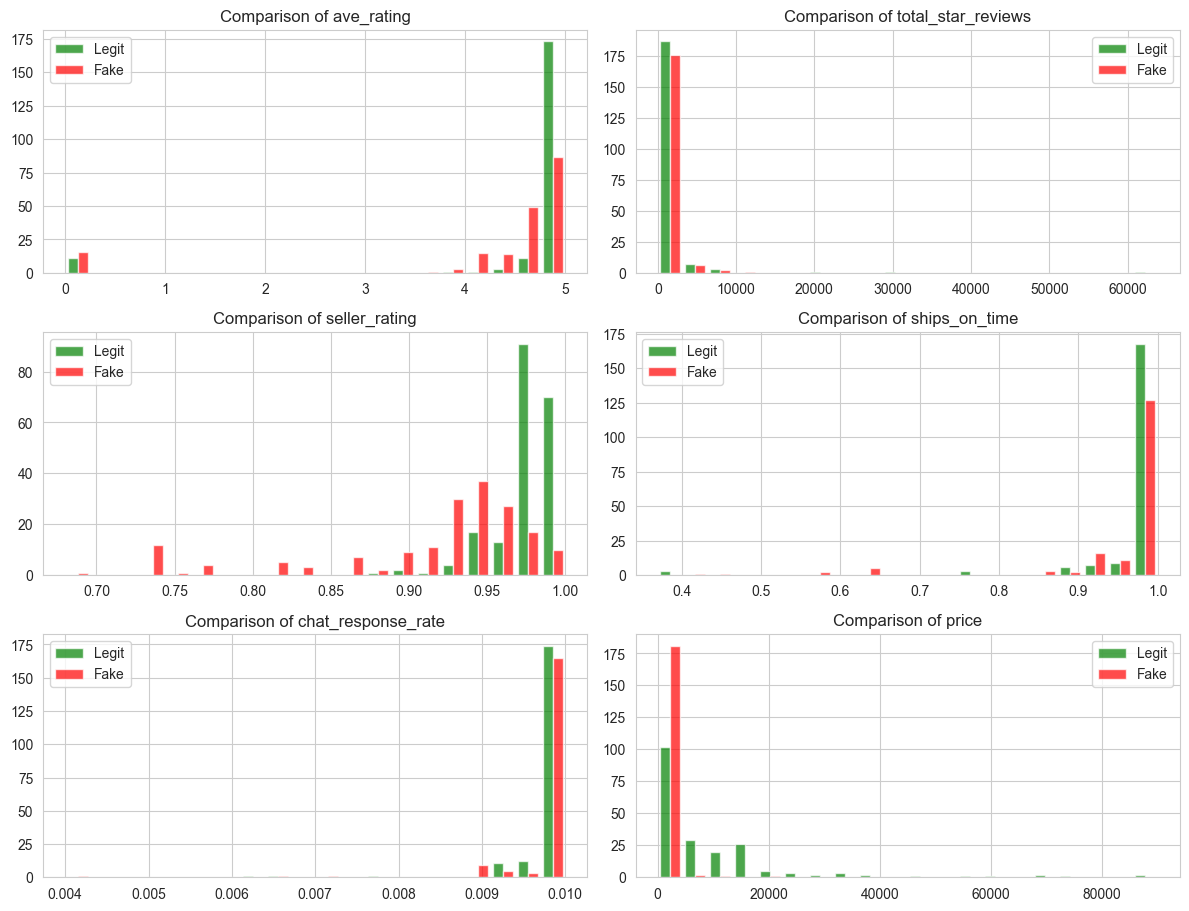

In [12]:
df['total_star_reviews'] = df['reviews_total_5_stars'] + df['reviews_total_4_stars'] + df['reviews_total_3_stars'] + df['reviews_total_2_stars'] + df['reviews_total_1_stars']

columns = ['ave_rating', 'total_star_reviews', 'seller_rating', 'ships_on_time', 'chat_response_rate', 'price']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))  
axes = axes.flatten()

for i, col in enumerate(columns):
    axes[i].hist([df[df['classification'] == 'Legit'][col], df[df['classification'] == 'Fake'][col]], 
                 label=['Legit', 'Fake'], alpha=0.7, bins=20, color=['green', 'red'])
    axes[i].set_title(f'Comparison of {col}')
    axes[i].legend()
    
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## **Model Training**

In [13]:
model = RandomForestClassifier(random_state=42)
model

RandomForestClassifier(random_state=42)

In [14]:
param_grid = {
    'n_estimators': [100, 150, 200, 300],  
    'max_features': ['sqrt', 'log2'], 
    'max_depth' : [None],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]
}

In [15]:
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='recall', n_jobs=-1)
grid_search.fit(X_combined, y)

print("Best parameters: ", grid_search.best_params_)
print("\nBest cross-validation/Recall score: {:.2f}".format(grid_search.best_score_))

Best parameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Best cross-validation/Recall score: 0.97


In [16]:
results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]), 
                     pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["score"])], axis=1)

# results.to_csv('final_grid_search_results.csv', index=False)

In [17]:
print("\nTop 5 high performing parameter variations combinations:")    
print(results.sort_values('score', ascending=False).head())


Top 5 high performing parameter variations combinations:
    criterion max_depth max_features  min_samples_leaf  min_samples_split  \
124   entropy      None         log2                 2                  5   
143   entropy      None         log2                 4                 10   
133   entropy      None         log2                 4                  2   
70       gini      None         log2                 4                 10   
66       gini      None         log2                 4                  5   

     n_estimators  score  
124           100  0.965  
143           300  0.960  
133           150  0.960  
70            200  0.960  
66            200  0.960  


In [18]:
print("\nTop 5 low performing parameter variations combinations:")    
print(results.sort_values('score', ascending=True).head())


Top 5 low performing parameter variations combinations:
    criterion max_depth max_features  min_samples_leaf  min_samples_split  \
117   entropy      None         log2                 1                 10   
118   entropy      None         log2                 1                 10   
45       gini      None         log2                 1                 10   
26       gini      None         sqrt                 4                  2   
44       gini      None         log2                 1                 10   

     n_estimators  score  
117           150  0.900  
118           200  0.905  
45            150  0.910  
26            200  0.910  
44            100  0.910  


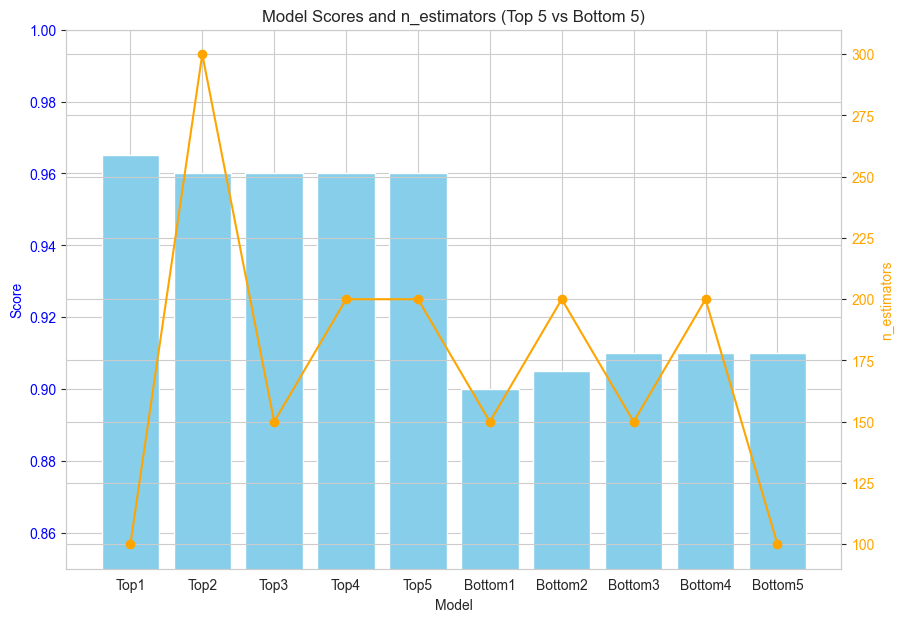

In [19]:
data = {
    'Model': ['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Bottom1', 'Bottom2', 'Bottom3', 'Bottom4', 'Bottom5'],
    'score': [0.965, 0.960, 0.960, 0.960, 0.960, 0.900, 0.905, 0.910, 0.910, 0.910],
    'n_estimators': [100, 300, 150, 200, 200, 150, 200, 150, 200, 100]
}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.bar(df['Model'], df['score'], color='skyblue', label='Score')
ax1.set_xlabel('Model')
ax1.set_ylabel('Score', color='blue')
ax1.set_ylim([0.85, 1])  # Setting a reasonable range for score
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df['Model'], df['n_estimators'], color='orange', marker='o', label='n_estimators')
ax2.set_ylabel('n_estimators', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Model Scores and n_estimators (Top 5 vs Bottom 5)')
plt.show()

In [20]:
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

## **Model Evaluation**

In [21]:
best_model = grid_search.best_estimator_

# joblib.dump(best_model, 'rfrst_model_final.joblib')
# joblib.dump(tfidf_vectorizer, 'tf_idf_final.joblib')

y_pred = best_model.predict(X_combined)
accuracy = accuracy_score(y, y_pred)

print("Accuracy Score: {:.2%}".format(accuracy))

Accuracy Score: 96.36%


### **Load & Test the Model**

In [22]:
from joblib import load
from scipy.sparse import hstack

In [23]:
model = load('rfrst_model_final.joblib')
model

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [24]:
text = 'Apple iPhone 11'
reviews_total_5_stars = 476
reviews_total_4_stars = 2
reviews_total_3_stars = 0
reviews_total_2_stars = 0
reviews_total_1_stars = 2
seller_rating = 0.95
ships_on_time = 0.99   
chat_response_rate = 0
ave_rating = 5.0
num_ratings = 480
price = 16390.00

X_text = tfidf_vectorizer.transform([text])
X_reviews = np.array([[reviews_total_5_stars, reviews_total_4_stars, reviews_total_3_stars, reviews_total_2_stars, reviews_total_1_stars]])
X_seller = np.array([[seller_rating, ships_on_time, chat_response_rate]])
X_combined = hstack((X_text, X_reviews, X_seller))

probability = model.predict_proba(X_combined)
print(probability)
print(f'Probability of listing being fake: {probability[0, 0]:.2%}')

[[0.37903737 0.62096263]]
Probability of listing being fake: 37.90%


In [25]:
text = 'Samsung Galaxy S23 Ultra cellphone original big sale android phone smartphone 12GB+512GB cheap mobile 7.5 inch gaming phone lowest price cellphone free shipping Cheap phone COD Live today'
reviews_total_5_stars = 321
reviews_total_4_stars = 0
reviews_total_3_stars = 1
reviews_total_2_stars = 0
reviews_total_1_stars = 5
seller_rating = 0.89
ships_on_time = 1.00   
chat_response_rate = 1.00
ave_rating = 4.9
num_ratings = 327
price = 2315.03

X_text = tfidf_vectorizer.transform([text])
X_reviews = np.array([[reviews_total_5_stars, reviews_total_4_stars, reviews_total_3_stars, reviews_total_2_stars, reviews_total_1_stars]])
X_seller = np.array([[seller_rating, ships_on_time, chat_response_rate]])
X_combined = hstack((X_text, X_reviews, X_seller))

probability = model.predict_proba(X_combined)
print(probability)
print(f'Probability of listing being fake: {probability[0, 0]:.2%}')

[[0.84637745 0.15362255]]
Probability of listing being fake: 84.64%
